In [113]:
import os

In [114]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [115]:
os.chdir("../.")

In [116]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [117]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [118]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelTrainingConfig:
    """Configuration for model training.
    """
    model_name: str
    root_dir: Path
    test_data_dir: Path
    train_data_dir: Path
    #criterion: str
    #max_features: int
    #min_samples_split: int
    #min_samples_leaf: int
    n_estimators: int
    #max_depth: int
    random_state: int
    #class_weight: str
    #n_jobs: int
    target_column: str
    booster: str
    
    objective: str
    num_class: int
    n_estimators: int
    learning_rate: float
    max_depth: int
    subsample: float        
    colsample_bytree: float
    random_state: int   
    
    
    random_state: int

    

In [119]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [120]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_training_config(self) -> ModelTrainingConfig:
        config = self.config.model_training
        params = self.params.xgb_classifier
        schema =  self.schema.target_column

        create_directories([self.config.artifacts_root])

        model_training_config = ModelTrainingConfig(
            root_dir=Path(config.root_dir),
            train_data_dir = Path(config.train_data_dir),
            test_data_dir = Path(config.test_data_dir),
            model_name = config.model_name,
            #criterion = params.criterion,
            #max_features = params.max_features,
            #min_samples_split = params.min_samples_split,
            #min_samples_leaf = params.min_samples_leaf,
            n_estimators = params.n_estimators, 
            #max_depth = params.max_depth,
            random_state = params.random_state,
            #class_weight = params.class_weight,
            #n_jobs = params.n_jobs,
            target_column = schema.name,
            objective = params.objective,
            num_class = params.num_class,
            learning_rate = params.learning_rate,
            subsample = params.subsample,
            colsample_bytree = params.colsample_bytree,
            max_depth = params.max_depth,
            booster = params.booster
                           
            
        )

        return model_training_config

In [121]:
import pandas as pd
import os
from BankProducts import logger
from sklearn.ensemble import RandomForestClassifier


import joblib
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier






In [122]:
class ModelTraining:
    def __init__(self, config: ModelTrainingConfig):
        self.config = config
        self.model = None

    def train(self):
        logger.info("Loading training data")
        train_data = pd.read_csv(self.config.train_data_dir)
        X_train = train_data.drop(columns=[self.config.target_column])
        y_train = train_data[self.config.target_column]
        
        # encode the target variable if it's categorical
        if y_train.dtype == 'object' or y_train.dtype.name == 'category':
            logger.info("Encoding target variable")
            label_encoder = LabelEncoder()
            y_train = label_encoder.fit_transform(y_train)
        else:
            logger.info("Target variable is already numeric, no encoding needed")   
        logger.info("Loading validation data")
        
        
        logger.info("Training the model")
        # Identify categorical and numerical features
        categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
        numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
      
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                ('num', SimpleImputer(strategy='mean'), numerical_features)
            ],
            remainder='passthrough'  # Keep other columns as they are
        )

        # Initialize the RandomForestClassifier with the provided configuration
        model = XGBClassifier(
            objective=self.config.objective,
            booster=self.config.booster,
            num_class=self.config.num_class,
            n_estimators=self.config.n_estimators,
            learning_rate=self.config.learning_rate,
            max_depth=self.config.max_depth,
            subsample=self.config.subsample,
            colsample_bytree=self.config.colsample_bytree,
            random_state=self.config.random_state
        )
        

        # Create the pipeline combining preprocessing, scaling, and modeling
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), numerical_features)
            ]
        )

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Fit the pipeline to the training data
        
        
        print("X_TRAIN", X_train[:15])
        print("Y_train", y_train[:10])

        pipeline.fit(X_train, y_train)
        
        import numpy as np

        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Get importances
        importances = classifier.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]

        print("Top 20 important features:")
        for i in sorted_indices[:20]:
            print(f"{feature_names[i]}: {importances[i]:.4f}")


        logger.info("Saving the trained model")
        
                
        # Create directory if it doesn't exist
        model_dir = self.config.root_dir
        os.makedirs(model_dir, exist_ok=True)
        
        print("Model directory:", model_dir)
        print("Directory exists?", os.path.exists(model_dir))
        print("Is a directory?", os.path.isdir(model_dir))

                
        model_path = os.path.join(model_dir, self.config.model_name)
        
        print("Model path:", model_path)
        # Ensure the model path is a Path object
        model_path = Path(model_path)
        
        
        

        
        print("Model will be saved to:", model_path)
        
                # Safety check: if a directory exists where the model file should go, delete it
        if os.path.isdir(model_path):
            import shutil
            logger.warning(f"A folder exists at model path '{model_path}', deleting it.")
            shutil.rmtree(model_path)
            
        # Save the model to the specified path
        self.model = pipeline 

   
        # Save the model using joblib
        joblib.dump(self.model, model_path, compress=4)
      
        
        logger.info("Model training completed successfully")
        
        import seaborn as sns
        import matplotlib.pyplot as plt

        for feature in ['annual_income', 'credit_score', 'age']:
            plt.figure(figsize=(8,4))
            sns.boxplot(x='product_name', y=feature, data=train_data)
            plt.title(f'{feature} by Product')
            plt.show()


[2025-05-31 22:40:13,403: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-31 22:40:13,417: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-31 22:40:13,428: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-31 22:40:13,432: INFO: common: created directory at: artifacts]
[2025-05-31 22:40:13,435: INFO: common: created directory at: artifacts]
[2025-05-31 22:40:13,438: INFO: 767250790: Loading training data]
[2025-05-31 22:40:13,600: INFO: 767250790: Encoding target variable]
[2025-05-31 22:40:13,619: INFO: 767250790: Loading validation data]
[2025-05-31 22:40:13,621: INFO: 767250790: Training the model]
X_TRAIN     age  annual_income marital_status  credit_score
0    35      192313.99       Divorced           396
1    58       97386.32       Divorced           716
2    30      157317.72       Divorced           535
3    18      150524.29       Divorced           801
4    26      104361.23       Divorced           417
5    39  

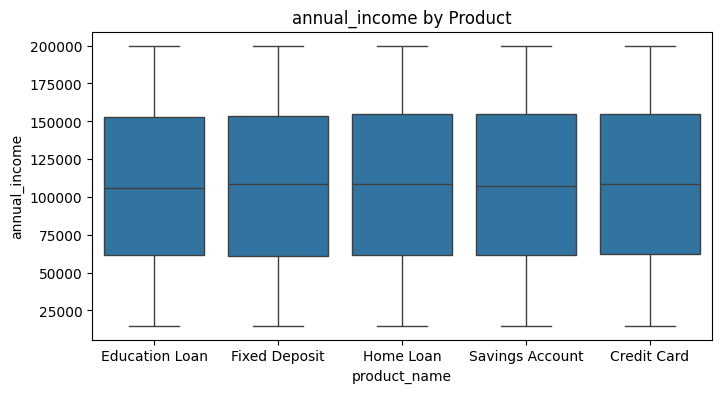

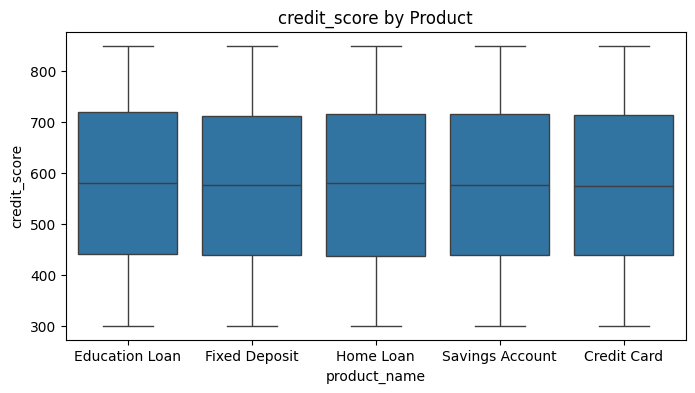

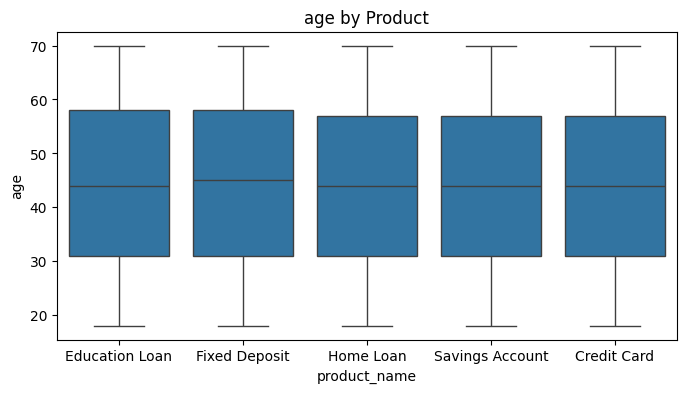

In [123]:
try:
    config = ConfigurationManager()
    model_training_config = config.get_model_training_config()
    model_trainer = ModelTraining(config=model_training_config)
    model_trainer.train()
except Exception as e:
    logger.exception(f"An error occurred during model training: {e}")
    